In [1]:
import warnings
import pandas as pd
import utils
import plotly.express as px
import numpy as np

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Calculating mean Average Precision (mAP) for CellProfiler features
In this notebook, we calculate the mAP perturbation detection for the CellProfiler features. We only use ORFs that are in different well positions.

All ORF plates from the `2020_11_04_CPJUMP1` batch are read, except for the ones with antibiotics (Blasticidin)

In [2]:
replicability_map_df = pd.DataFrame()
replicability_fr_df = pd.DataFrame()

batch = "2020_11_04_CPJUMP1"
modality_perturbation = "orf"
batch_size = 100000
null_size = 100000

experiment_df = (
    pd.read_csv("output/experiment-metadata.tsv", sep="\t")
    .query("Batch==@batch")
    .query("Perturbation=='orf'")
    .query('Antibiotics=="absent"')
)


Normalized, feature selected ORF profiles for replicate plates at the same time point, using the same cell type are merged into a single data frame. Empty wells are removed before calculating mAP for perturbation detection (retrieve replicates of the query compound). p value and FDR corrected p values are calculated using a permutation-based significance test.

Along with mAP, fraction retrieved is also calculated. This is the fraction of queries that have qvalue < 0.05.

The mAP and fraction retrieved values as saved to `output` directory and the results are plotted.

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query("Cell_type==@cell")
    modality_experiments_df = cell_df.copy()
    
    for modality_timepoint in modality_experiments_df.Time.unique():
        modality_timepoint_df = modality_experiments_df.query(
            "Time==@modality_timepoint"
        )

        modality_df = pd.DataFrame()
        for plate in modality_timepoint_df.Assay_Plate_Barcode.unique():
            data_df = (
                utils.load_data(
                    batch,
                    plate,
                    "normalized_feature_select_negcon_batch.csv.gz",
                )
                .assign(Metadata_modality=modality_perturbation)
                .assign(Metadata_matching_target=lambda x: x.Metadata_gene)
            )
            modality_df = utils.concat_profiles(modality_df, data_df)

        # Remove empty wells
        modality_df = utils.remove_empty_wells(modality_df)

        # Description
        description = f"{modality_perturbation}_{cell}_{utils.time_point(modality_perturbation, modality_timepoint)}"

        # Calculate replicability mAP

        print(f"Computing {description} replicability")

        modality_df["Metadata_negcon"] = np.where(
            modality_df["Metadata_control_type"] == "negcon", 1, 0
        )  # Create dummy column

        pos_sameby = ["Metadata_broad_sample", "Metadata_Well"]
        pos_diffby = []
        neg_sameby = ["Metadata_Plate"]
        neg_diffby = ["Metadata_negcon"]

        metadata_df = utils.get_metadata(modality_df)
        feature_df = utils.get_featuredata(modality_df)
        feature_values = feature_df.values

        result = utils.run_pipeline(
            metadata_df,
            feature_values,
            pos_sameby,
            pos_diffby,
            neg_sameby,
            neg_diffby,
            anti_match=False,
            batch_size=batch_size,
            null_size=null_size,
        )

        result = result.query("Metadata_negcon==0").reset_index(drop=True)

        (
            replicability_map_df,
            replicability_fr_df,
        ) = utils.create_replicability_df(
            replicability_map_df,
            replicability_fr_df,
            result,
            pos_sameby,
            0.05,
            modality_perturbation,
            cell,
            modality_timepoint,
        )

Computing orf_A549_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_A549_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_U2OS_short replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing orf_U2OS_long replicability


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Tables of mAP values and the fraction retrieved (fr) are printed and bar plots are plotted.

Replicability fraction retrieved.

In [4]:
print(replicability_fr_df[["Description", "timepoint", "fr"]].to_markdown(index=False))

| Description    |   timepoint |    fr |
|:---------------|------------:|------:|
| orf_A549_long  |          96 | 0.247 |
| orf_A549_short |          48 | 0.234 |
| orf_U2OS_short |          48 | 0.425 |
| orf_U2OS_long  |          96 | 0.241 |


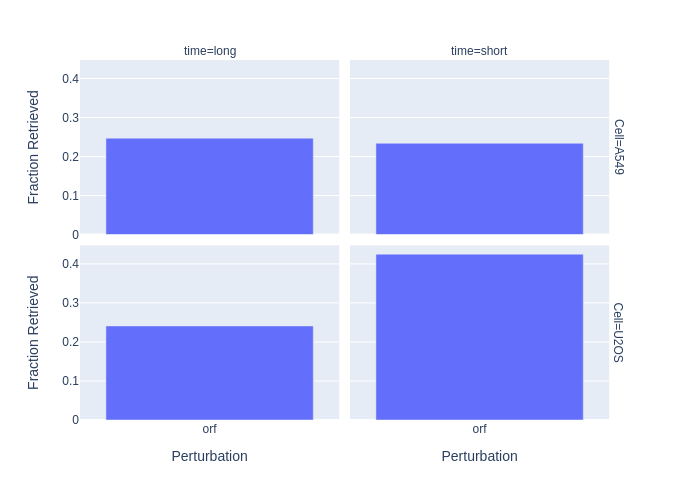

In [5]:
fig = px.bar(
    data_frame=replicability_fr_df,
    x="Modality",
    y="fr",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="Fraction Retrieved"),
    yaxis3=dict(title="Fraction Retrieved"),
)
fig.show("png")
fig.write_image(
    f"figures/1.2.CellProfiler_replicability_orf_different_fr.png", width=640, height=480, scale=2
)

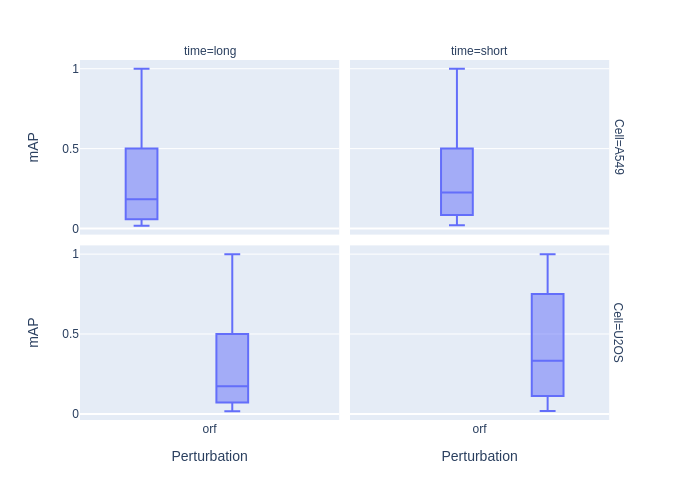

In [6]:
fig = px.box(
    data_frame=replicability_map_df,
    x="Modality",
    y="mean_average_precision",
    facet_row="Cell",
    facet_col="time",
)
fig.update_layout(
    xaxis1=dict(title="Perturbation"),
    xaxis2=dict(title="Perturbation"),
    yaxis1=dict(title="mAP"),
    yaxis3=dict(title="mAP"),
)
fig.show("png")
fig.write_image(
    f"figures/1.2.CellProfiler_replicability_orf_different_map.png", width=640, height=480, scale=2
)

Tables of mAP and fr values are written to file.

In [7]:
replicability_fr_df.to_csv("output/cellprofiler_replicability_orf_different_fr.csv", index=False)
replicability_map_df.to_csv("output/cellprofiler_replicability_orf_different_map.csv", index=False)